# Лабораторная работа №4

ФИО: Дулян Арсен Артурович
Группа: БИВТ-23-СП-1

Отправлять можно следующими способами:
1. Запушить этот ноутбук в GitHub в репозиторий, где у вас лежат ноутбуки с лабами

Deadlines:
- Занятие №7 в семестре

Что необходимо сделать:  
- Обучить различные модели глубокого обучения на имеющихся данных  

---
## Читайте задание внимательно

Исходные данные:
1. В [табличке](https://docs.google.com/spreadsheets/d/1NOE0D4JQgD6LbvUqWboUI1TFj4P87ugbqUTDquxlGEI/edit?usp=sharing) необходимо узнать название своего датасета 
2. Скачать нужны вам данные можно в [Google Drive](https://drive.google.com/drive/folders/1sbsjBsJ_ln0XgXCI9R6s17pvyvApgcwF?usp=sharing)
  
---
Теперь по пунктам, что я от вас жду:  
1. Загрузить необходимые данные к себе и считать (read) их в переменную.
2. Понять, у вас задача классификации (бинарной или многоклассовой) или регрессии.
3. Сделать предобработку данных:  
     1. Разделить выборку на тренировочную (train) и тестовую (test). _Обратите внимание, что обучать скейлеры и определять, какими значениями вы будете заполнять пропуски, вы будете на train выборке, а применять и на train, и на test_.
     2. Проверить пропуски в данных. Если они есть, заполнить одной из стратегий, предложенных в ноутбуке для семинара №3. P.S. Для численных и категориальных переменных будут разные стратегии.
     3. Отнормировать численные переменные (`StandardScaler`, `MinMaxScaler`).
     4. Закодировать категориальные признаки по одной из стратегий.
4. Оформить данные в виде класса `Dataset` из библиотеки `torch` (как мы это делали на семинаре), а затем засунуть в `Dataloader` (тоже делали на семинаре).
5. Обучить на тренировочном множестве:
     1. Очень простую однослойную нейросеть с оптимизатором `SGD` ([link](https://pytorch.org/docs/stable/optim.html)).
     2. Нейросеть посложнее (с 1 скрытым слоем) с оптимизатором `Adam` ([link](https://pytorch.org/docs/stable/optim.html)).
     3. Нейросеть еще сложнее (с 3+ скрытыми слоями) с оптимизатором `Adam` ([link](https://pytorch.org/docs/stable/optim.html)).
6. Посчитайте loss на train и test множествах, в зависимости от эпохи обучения. Провизуализируйте это с помощью библиотеки `matplotlib` (выйдет так называемая **learning curve**, кривая обучения модели).
6. Посчитайте метрики на train и test множествах:
     1. Для задачи классификации -- Accuracy
     2. Для задачи регрессии -- MAE
7. Сравните метрики относительно train/test, так и относительно разных моделей. Ответьте на следующие вопросы:
     1. Какая модель справилась лучше с поставленной задачей?
     2. Имеет ли место переобучение?
     3. Имеет ли место недообучение?
     4. Как можно улучшить метрики моделей?

---
P.S.  
Просьба -- делать каждое задание в отдельных ячейках и с отдельными заголовками (как пункт 1 и 2 в этом ноутбуке) типа  
- Заголовок
- Ячейки с кодом
- Другой заголовок
- Другие ячейки с кодом

P.S.S.  
Если вам повезло с многоклассовой классификацией, у вас не будет проблем, просто нужно будет поставить необходимое количество нейронов на выходе вашей нейросети.

## 1. Загрузка данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('/Users/lekzyrs/Desktop/ailabs/data/spotify-2023.csv', sep=',', encoding='latin-1')

print(f"Размер датасета: {data.shape}")
print(f"\nПервые 5 строк:")
print(data.head())
print(f"\nИнформация о датасете:")
print(data.info())

Размер датасета: (952, 24)

Первые 5 строк:
                            track_name    artist(s)_name  artist_count  \
0  Seven (feat. Latto) (Explicit Ver.)  Latto, Jung Kook             2   
1                                 LALA       Myke Towers             1   
2                              vampire    Olivia Rodrigo             1   
3                         Cruel Summer      Taylor Swift             1   
4                       WHERE SHE GOES         Bad Bunny             1   

   released_year  released_month  released_day  in_spotify_playlists  \
0           2023               7            14                   553   
1           2023               3            23                  1474   
2           2023               6            30                  1397   
3           2019               8            23                  7858   
4           2023               5            18                  3133   

   in_spotify_charts    streams  in_apple_playlists  ...  bpm key   mode  \
0 

## 2. Понимаем, какая перед нами задача

In [ ]:
target_variable = 'streams'

if target_variable in data.columns:
    data[target_variable] = data[target_variable].astype(str).str.replace(',', '').astype(float)

unique_values = data[target_variable].nunique()
is_continuous = data[target_variable].dtype in ['float64', 'int64', 'float32', 'int32']

if is_continuous and unique_values > 20:
    task_type = "РЕГРЕССИЯ"
elif unique_values == 2:
    task_type = "БИНАРНАЯ КЛАССИФИКАЦИЯ"
else:
    task_type = "МНОГОКЛАССОВАЯ КЛАССИФИКАЦИЯ"

print(f"Тип задачи: {task_type}")


Тип задачи: РЕГРЕССИЯ


## 3. Делаем предобработку данных

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer

target_variable = 'streams'

if target_variable in data.columns:
    if data[target_variable].dtype == 'object':
        data[target_variable] = data[target_variable].astype(str).str.replace(',', '').astype(float)

X = data.drop(columns=[target_variable])
y = data[target_variable]

X = X.drop(columns=['track_name', 'artist(s)_name'], errors='ignore')

for col in X.columns:
    if X[col].dtype == 'object':
        try:
            X[col] = X[col].astype(str).str.replace(',', '').astype(float)
        except:
            pass
print(f"Размер признаков: {X.shape}")
print(f"Размер целевой переменной: {y.shape}")


Размер признаков: (952, 21)
Размер целевой переменной: (952,)


### 3.1. Разделение на train и test


In [18]:
# Разделение на train и test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Размер train выборки: {X_train.shape}")
print(f"Размер test выборки: {X_test.shape}")


Размер train выборки: (761, 21)
Размер test выборки: (191, 21)


### 3.2. Проверка и заполнение пропусков


In [ ]:
# Проверяем пропуски в train выборке
print("Пропуски в train выборке:")
print(X_train.isnull().sum()[X_train.isnull().sum() > 0])

# Разделяем на численные и категориальные признаки
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

print(f"\nЧисленные признаки: {len(numeric_cols)}")
print(f"Категориальные признаки: {len(categorical_cols)}")

# Обучаем импьютеры на train выборке
numeric_imputer = SimpleImputer(strategy='median')
X_train[numeric_cols] = numeric_imputer.fit_transform(X_train[numeric_cols])

# Для категориальных признаков - наиболее частое значение
categorical_imputer = SimpleImputer(strategy='most_frequent')
if categorical_cols:
    X_train[categorical_cols] = categorical_imputer.fit_transform(X_train[categorical_cols])

# Применяем импьютеры к test выборке
X_test[numeric_cols] = numeric_imputer.transform(X_test[numeric_cols])
if categorical_cols:
    X_test[categorical_cols] = categorical_imputer.transform(X_test[categorical_cols])

print("\nПропуски после заполнения:")
print(f"Train: {X_train.isnull().sum().sum()}")
print(f"Test: {X_test.isnull().sum().sum()}")


Пропуски в train выборке:
in_shazam_charts    42
key                 80
dtype: int64

Численные признаки: 19
Категориальные признаки: 2

Пропуски после заполнения:
Train: 0
Test: 0


### 3.3. Нормализация численных переменных


In [20]:
# Используем StandardScaler для нормализации численных признаков
scaler = StandardScaler()

# Обучаем на train и применяем к train и test
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

print("Численные признаки нормализованы с помощью StandardScaler")
print(f"Пример нормализованных данных (первые 3 строки, первые 3 признака):")
print(X_train[numeric_cols[:3]].head(3))


Численные признаки нормализованы с помощью StandardScaler
Пример нормализованных данных (первые 3 строки, первые 3 признака):
     artist_count  released_year  released_month
318     -0.611873       0.332593        1.113503
545     -0.611873      -0.027696       -0.866347
557     -0.611873       0.332593       -1.432018


### 3.4. Кодирование категориальных признаков


In [21]:
# Используем OneHotEncoder для категориальных признаков
if categorical_cols:
    ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
    
    # Обучаем на train и применяем к train и test
    X_train_encoded = ohe.fit_transform(X_train[categorical_cols])
    X_test_encoded = ohe.transform(X_test[categorical_cols])
    
    # Создаем DataFrame с закодированными признаками
    feature_names = ohe.get_feature_names_out(categorical_cols)
    X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=feature_names, index=X_train.index)
    X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=feature_names, index=X_test.index)
    
    # Объединяем численные и закодированные категориальные признаки
    X_train_final = pd.concat([X_train[numeric_cols].reset_index(drop=True), 
                               X_train_encoded_df.reset_index(drop=True)], axis=1)
    X_test_final = pd.concat([X_test[numeric_cols].reset_index(drop=True), 
                              X_test_encoded_df.reset_index(drop=True)], axis=1)
    
    print(f"Категориальные признаки закодированы с помощью OneHotEncoder")
    print(f"Количество новых признаков после кодирования: {len(feature_names)}")
else:
    X_train_final = X_train[numeric_cols].reset_index(drop=True)
    X_test_final = X_test[numeric_cols].reset_index(drop=True)
    print("Категориальных признаков нет")

print(f"\nФинальный размер train: {X_train_final.shape}")
print(f"Финальный размер test: {X_test_final.shape}")
print(f"\nПервые 5 признаков:")
print(X_train_final.head())


Категориальные признаки закодированы с помощью OneHotEncoder
Количество новых признаков после кодирования: 11

Финальный размер train: (761, 30)
Финальный размер test: (191, 30)

Первые 5 признаков:
   artist_count  released_year  released_month  released_day  \
0     -0.611873       0.332593        1.113503      1.322189   
1     -0.611873      -0.027696       -0.866347     -0.528218   
2     -0.611873       0.332593       -1.432018     -0.528218   
3     -0.611873      -0.658202       -1.432018     -1.398997   
4      0.494150       0.332593        0.830667      0.886799   

   in_spotify_playlists  in_spotify_charts  in_apple_playlists  \
0             -0.593057          -0.517854           -0.510071   
1             -0.169046          -0.029881           -0.397661   
2             -0.407140          -0.615448           -0.307732   
3              1.174838           1.482833            0.220596   
4              0.407385           1.434036            1.659447   

   in_apple_charts 

## 4. PyTorch Dataset и DataLoader
Создаем класс `Dataset` для табличных данных и `DataLoader` для train/test.

In [ ]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader

class TabularDataset(Dataset):
    def __init__(self, X, y):
        # X: DataFrame or ndarray, y: Series or ndarray
        X_arr = X.values if hasattr(X, 'values') else np.array(X)
        y_arr = y.values if hasattr(y, 'values') else np.array(y)
        self.X = torch.tensor(X_arr, dtype=torch.float32)
        # для регрессии используем shape (N,1)
        self.y = torch.tensor(y_arr, dtype=torch.float32).reshape(-1, 1)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Создаем наборы и загрузчики
batch_size = 64
train_dataset = TabularDataset(X_train_final, y_train.reset_index(drop=True))
test_dataset = TabularDataset(X_test_final, y_test.reset_index(drop=True))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print('Train batches:', len(train_loader), 'Test batches:', len(test_loader))

Train batches: 12 Test batches: 3


## 5. Обучение моделей нейросетей

### 5.1. Однослойная нейросеть с оптимизатором SGD

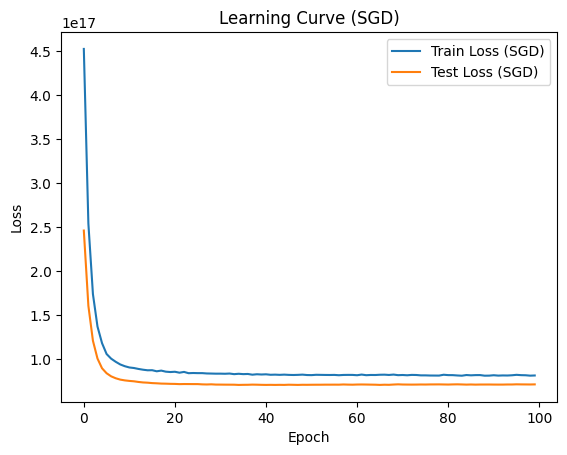

In [ ]:
#Стохастический градиентный спуск
import torch.nn as nn
import torch.optim as optim

# Определяем однослойную нейросеть
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc = nn.Linear(input_dim, 1)  # одно выходное значение для регрессии

    def forward(self, x):
        return self.fc(x)

# Инициализируем модель, функцию потерь и оптимизатор
input_dim = X_train_final.shape[1]
model_sgd = SimpleNN(input_dim)
criterion = nn.MSELoss()
optimizer = optim.SGD(model_sgd.parameters(), lr=0.01)

# Обучение модели
num_epochs = 100
train_losses_sgd = []
test_losses_sgd = []

for epoch in range(num_epochs):
    model_sgd.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model_sgd(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    train_losses_sgd.append(epoch_loss / len(train_loader))
    
    # Тестирование
    model_sgd.eval()
    test_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model_sgd(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
    
    test_losses_sgd.append(test_loss / len(test_loader))

# Визуализация кривой обучения
plt.plot(train_losses_sgd, label='Train Loss (SGD)')
plt.plot(test_losses_sgd, label='Test Loss (SGD)')
plt.title('Learning Curve (SGD)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


### 5.2. Нейросеть с одним скрытым слоем и оптимизатором Adam

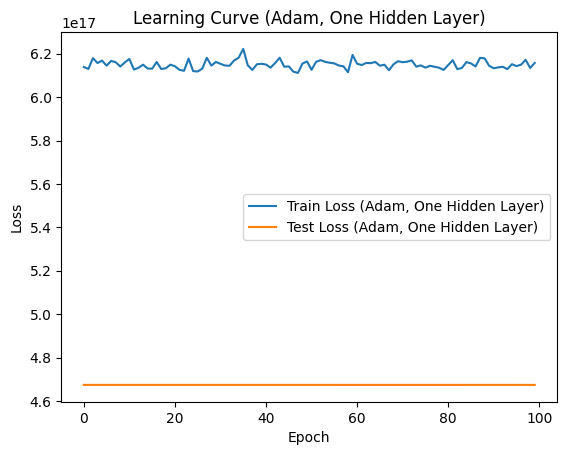

In [24]:
# Определяем нейросеть с одним скрытым слоем
class OneHiddenNN(nn.Module):
    def __init__(self, input_dim):
        super(OneHiddenNN, self).__init__()
        self.hidden = nn.Linear(input_dim, 10)  # скрытый слой
        self.output = nn.Linear(10, 1)           # выходной слой

    def forward(self, x):
        x = torch.relu(self.hidden(x))
        return self.output(x)

# Инициализируем модель, функцию потерь и оптимизатор
model_adam_one_hidden = OneHiddenNN(input_dim)
optimizer = optim.Adam(model_adam_one_hidden.parameters(), lr=0.01)

# Обучение модели
train_losses_adam_one_hidden = []
test_losses_adam_one_hidden = []

for epoch in range(num_epochs):
    model_adam_one_hidden.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model_adam_one_hidden(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    train_losses_adam_one_hidden.append(epoch_loss / len(train_loader))
    
    # Тестирование
    model_adam_one_hidden.eval()
    test_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model_adam_one_hidden(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
    
    test_losses_adam_one_hidden.append(test_loss / len(test_loader))

# Визуализация кривой обучения
plt.plot(train_losses_adam_one_hidden, label='Train Loss (Adam, One Hidden Layer)')
plt.plot(test_losses_adam_one_hidden, label='Test Loss (Adam, One Hidden Layer)')
plt.title('Learning Curve (Adam, One Hidden Layer)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


### 5.3. Нейросеть с 3 скрытыми слоями и оптимизатором Adam

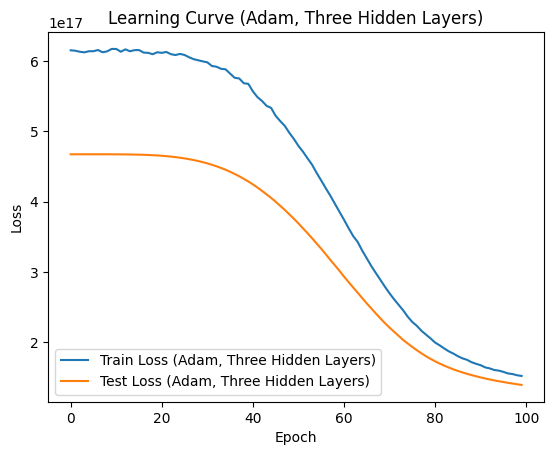

In [25]:
# Определяем нейросеть с 3 скрытыми слоями
class ThreeHiddenNN(nn.Module):
    def __init__(self, input_dim):
        super(ThreeHiddenNN, self).__init__()
        self.hidden1 = nn.Linear(input_dim, 20)  # первый скрытый слой
        self.hidden2 = nn.Linear(20, 15)         # второй скрытый слой
        self.hidden3 = nn.Linear(15, 10)         # третий скрытый слой
        self.output = nn.Linear(10, 1)           # выходной слой

    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = torch.relu(self.hidden3(x))
        return self.output(x)

# Инициализируем модель, функцию потерь и оптимизатор
model_adam_three_hidden = ThreeHiddenNN(input_dim)
optimizer = optim.Adam(model_adam_three_hidden.parameters(), lr=0.01)

# Обучение модели
train_losses_adam_three_hidden = []
test_losses_adam_three_hidden = []

for epoch in range(num_epochs):
    model_adam_three_hidden.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model_adam_three_hidden(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    train_losses_adam_three_hidden.append(epoch_loss / len(train_loader))
    
    # Тестирование
    model_adam_three_hidden.eval()
    test_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model_adam_three_hidden(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
    
    test_losses_adam_three_hidden.append(test_loss / len(test_loader))

# Визуализация кривой обучения
plt.plot(train_losses_adam_three_hidden, label='Train Loss (Adam, Three Hidden Layers)')
plt.plot(test_losses_adam_three_hidden, label='Test Loss (Adam, Three Hidden Layers)')
plt.title('Learning Curve (Adam, Three Hidden Layers)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## 6. Вычисление потерь на обучающей и тестовой выборках

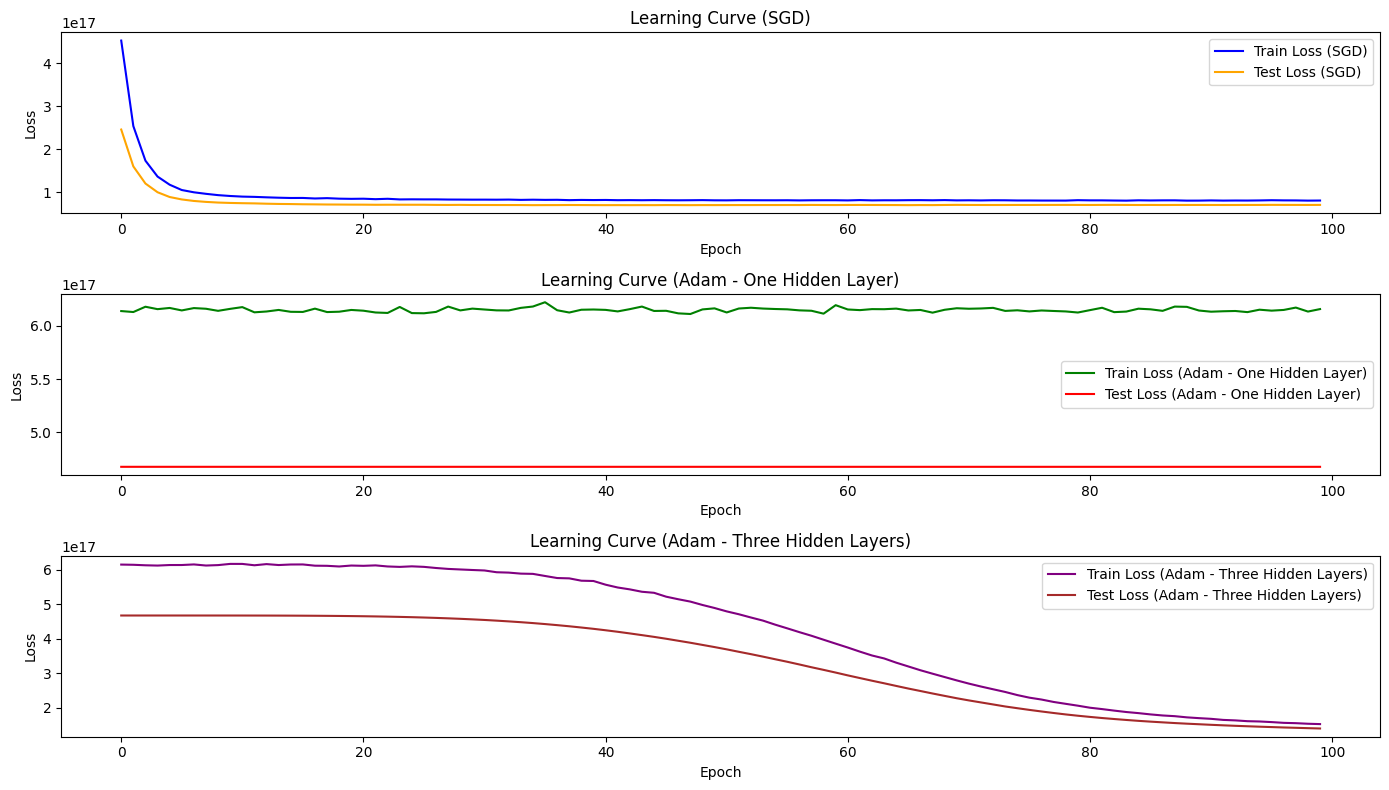

In [26]:
# Визуализация потерь для всех моделей
plt.figure(figsize=(14, 8))

# Кривая для модели с SGD
plt.subplot(3, 1, 1)
plt.plot(train_losses_sgd, label='Train Loss (SGD)', color='blue')
plt.plot(test_losses_sgd, label='Test Loss (SGD)', color='orange')
plt.title('Learning Curve (SGD)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Кривая для модели с Adam и одним скрытым слоем
plt.subplot(3, 1, 2)
plt.plot(train_losses_adam_one_hidden, label='Train Loss (Adam - One Hidden Layer)', color='green')
plt.plot(test_losses_adam_one_hidden, label='Test Loss (Adam - One Hidden Layer)', color='red')
plt.title('Learning Curve (Adam - One Hidden Layer)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Кривая для модели с Adam и тремя скрытыми слоями
plt.subplot(3, 1, 3)
plt.plot(train_losses_adam_three_hidden, label='Train Loss (Adam - Three Hidden Layers)', color='purple')
plt.plot(test_losses_adam_three_hidden, label='Test Loss (Adam - Three Hidden Layers)', color='brown')
plt.title('Learning Curve (Adam - Three Hidden Layers)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## 7. MAE

In [33]:
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error

# Функция для расчета MAE на train множестве
def calculate_mae_train(model, data_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)
            predictions.extend(outputs.numpy())
            actuals.extend(targets.numpy())
    return mean_absolute_error(actuals, predictions)

# Функция для расчета MAE на test множестве
def calculate_mae(model, data_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)
            predictions.extend(outputs.numpy())
            actuals.extend(targets.numpy())
    return mean_absolute_error(actuals, predictions)

# Cоздаем DataLoader для train множества
train_loader_sgd = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
train_loader_adam_one_hidden = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
train_loader_adam_three_hidden = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# Проверяем MAE для каждой модели на train множестве
mae_train_sgd = calculate_mae_train(model_sgd, train_loader_sgd)
mae_train_adam_one_hidden = calculate_mae_train(model_adam_one_hidden, train_loader_adam_one_hidden)
mae_train_adam_three_hidden = calculate_mae_train(model_adam_three_hidden, train_loader_adam_three_hidden)

print(f"MAE на train для модели с SGD: {mae_train_sgd:.4f}")
print(f"MAE на train для модели с Adam (1 скрытый слой): {mae_train_adam_one_hidden:.4f}")
print(f"MAE на train для модели с Adam (3 скрытых слоя): {mae_train_adam_three_hidden:.4f}")

# Проверяем MAE для каждой модели на test множестве
mae_test_sgd = calculate_mae(model_sgd, test_loader)
mae_test_adam_one_hidden = calculate_mae(model_adam_one_hidden, test_loader)
mae_test_adam_three_hidden = calculate_mae(model_adam_three_hidden, test_loader)

print(f"MAE на test для модели с SGD: {mae_test_sgd:.4f}")
print(f"MAE на test для модели с Adam (1 скрытый слой): {mae_test_adam_one_hidden:.4f}")
print(f"MAE на test для модели с Adam (3 скрытых слоя): {mae_test_adam_three_hidden:.4f}")


MAE на train для модели с SGD: 189367443.5848
MAE на train для модели с Adam (1 скрытый слой): 524729341.8769
MAE на train для модели с Adam (3 скрытых слоя): 269558303.9423
MAE на test для модели с SGD: 187062007.7801
MAE на test для модели с Adam (1 скрытый слой): 471892878.0746
MAE на test для модели с Adam (3 скрытых слоя): 262516365.4192


## 8. Сравнение метрик

In [32]:
import pandas as pd

# Результаты MAE для каждой модели
results_mae = {
    'Model': [
        'SGD (Single Layer)', 
        'Adam (One Hidden Layer)', 
        'Adam (Three Hidden Layers)'
    ],
    'MAE Train': [
        mae_train_sgd, 
        mae_train_adam_one_hidden, 
        mae_train_adam_three_hidden
    ],
    'MAE Test': [
        mae_test_sgd, 
        mae_test_adam_one_hidden, 
        mae_test_adam_three_hidden
    ]
}

results_mae_df = pd.DataFrame(results_mae)

# Отображение результатов
print(results_mae_df)


                        Model     MAE Train      MAE Test
0          SGD (Single Layer)  1.893674e+08  1.870620e+08
1     Adam (One Hidden Layer)  5.247293e+08  4.718929e+08
2  Adam (Three Hidden Layers)  2.695583e+08  2.625164e+08


### Ответы на вопросы на основе данных результатов

### 1. Какая модель справилась лучше с поставленной задачей?

На основе данных результатов, наименьший **MAE Test** наблюдается у модели **SGD (Single Layer)**, что указывает на то, что эта модель справилась лучше всего с задачей

### 2. Имеет ли место переобучение?

- **SGD (Single Layer)**: MAE Train (1.893674e+08) близок к MAE Test (1.870620e+08), что указывает на отсутствие значительного переобучения.
- **Adam (One Hidden Layer)**: MAE Train (5.247293e+08) значительно выше MAE Test (4.718929e+08), что может указывать на явное переобучение.
- **Adam (Three Hidden Layers)**: MAE Train (2.695583e+08) также выше MAE Test (2.625164e+08), что также может свидетельствовать о переобучении.

### 3. Имеет ли место недообучение?

- Модели **Adam (One Hidden Layer)** и **Adam (Three Hidden Layers)** имеют значительно высокие значения MAE как на тренировочном, так и на тестовом наборах. Это может указывать на недообучение
- Модель **SGD (Single Layer)** демонстрирует приемлемые значения MAE на обоих наборах данных и не указывает на недообучение.

### 4. Как можно улучшить метрики моделей?

- **Увеличение объема данных**: Добавление данных для увеличения разнообразия обучения может помочь улучшить обобщающую способность модели.
- **Тонкая настройка гиперпараметров**: Эксперименты с размером батча, скоростью обучения и количеством эпох для нахождения оптимальных значений.
- **Использование других алгоритмов обучения**: Попробуйте использовать алгоритмы, которые могут лучше обрабатывать сложные зависимости в данных.